In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K

import cv2

import open3d as o3

from functools import partial

from mpl_toolkits.mplot3d import Axes3D
# from fastai.vision import Path
from pathlib import Path

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [4]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [5]:
def getCore(data):
    coreTmp = np.zeros((1, 3))
    coreTmp[:, 0] = np.sum(data[:, ::3], axis=1) / (data.shape[1] / 3)   #coreX
    coreTmp[:, 1] = np.sum(data[:, 1::3], axis=1) / (data.shape[1] / 3)  #coreY
    coreTmp[:, 2] = np.sum(data[:, 2::3], axis=1) / (data.shape[1] / 3)  #coreZ

    return coreTmp


def dataShift(data, core):    #使全部點剛好在第一象限
    data[:, ::3] = data[:, ::3] - core[0, 0]
    data[:, 1::3] = data[:, 1::3] - core[0, 1]
    data[:, 2::3] = data[:, 2::3] - core[0, 2]

    xShiftTmp = min(data[0, ::3])
    yShiftTmp = min(data[0, 1::3])
    zShiftTmp = min(data[0, 2::3])

    data[:, ::3] = data[:, ::3] - xShiftTmp
    data[:, 1::3] = data[:, 1::3] - yShiftTmp
    data[:, 2::3] = data[:, 2::3] - zShiftTmp

    return data


def getMaxRadius(data):
    maxTmp = 0
    indexTmp = 0

    for i in range(data.shape[1] // 3):
        tmp = np.sqrt(np.square(data[0, i*3]) + np.square(data[0, i*3 + 1]) + np.square(data[0, i*3 + 2]))
        if (tmp  > maxTmp):
            maxTmp = tmp
            indexTmp = i    

    return indexTmp, maxTmp


def getAABBSize(rdata):  
    xTmp = rdata[0, ::3]
    yTmp = rdata[0, 1::3]
    zTmp = rdata[0, 2::3]

    xDis = max(xTmp) - min(xTmp)
    yDis = max(yTmp) - min(yTmp)
    zDis = max(zTmp) - min(zTmp) 

    return xDis, yDis, zDis


def get3DMatrix(xDis, yDis, zDis, rData):
    MCount = np.zeros((mSize, mSize, mSize))
    MCount = MCount + 1e-7    #避免除零    
    MResult = np.zeros((mSize, mSize, mSize * 3))    #三通道
    MXSum = np.zeros((mSize, mSize, mSize))
    MYSum = np.zeros((mSize, mSize, mSize))
    MZSum = np.zeros((mSize, mSize, mSize))

    for i in range (rData.shape[1] // 3):
        D1Tmp = math.floor(rData[0, i*3] / xDis * mSize)
        D2Tmp = math.floor(rData[0, i*3 + 1] / yDis * mSize)
        D3Tmp = math.floor(rData[0, i*3 + 2] / zDis * mSize)
        
        D1Tmp = np.minimum(12, D1Tmp)
        D2Tmp = np.minimum(12, D2Tmp)
        D3Tmp = np.minimum(12, D3Tmp)
        
        D1Tmp = np.maximum(-12, D1Tmp)
        D2Tmp = np.maximum(-12, D2Tmp)
        D3Tmp = np.maximum(-12, D3Tmp)

        if D1Tmp != mSize and D2Tmp != mSize and D3Tmp != mSize:
            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
        else:
            D1Tmp = D1Tmp - 1 if D1Tmp == mSize else D1Tmp
            D2Tmp = D2Tmp - 1 if D2Tmp == mSize else D2Tmp
            D3Tmp = D3Tmp - 1 if D3Tmp == mSize else D3Tmp

            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
            
    MXSum = np.divide(MXSum, MCount)
    MYSum = np.divide(MYSum, MCount)
    MZSum = np.divide(MZSum, MCount)

    for i in range(mSize):
        MResult[:, :, i * 3] = MXSum[:, :, i]
        MResult[:, :, i * 3 + 1] = MYSum[:, :, i]
        MResult[:, :, i * 3 + 2] = MZSum[:, :, i]

    return MResult    

In [6]:
def invQ(q):
    absQ = np.sum(np.square(q))
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / absQ
    return invq


def rm2theta(rm):
    eps = 1e-16
    theta2 = np.arctan2(rm[0, 2], np.sqrt(np.power(rm[0, 0], 2) + np.power(rm[0, 1], 2)))
    theta1 = np.arctan2(-rm[1, 2]/ (np.cos(theta2)), rm[2, 2]/ (np.cos(theta2)) )
    theta3 = np.arctan2(-rm[0, 1]/ (np.cos(theta2)), rm[0, 0]/(np.cos(theta2)))
    
    theta1 = clip180(theta1)
    theta2 = clip90(theta2)
    theta3 = clip180(theta3)
    
    return np.array([theta1, theta2, theta3])


def theta2rm(theta):   
    theta1, theta2, theta3 = theta
    
    rm = np.zeros((3,3))
    rm[0,0] = math.cos(theta2) * math.cos(theta3)
    rm[0,1] = -math.cos(theta2) * math.sin(theta3)
    rm[0,2] = math.sin(theta2)
    
    rm[1,0] = math.cos(theta1) * math.sin(theta3) + math.cos(theta3) * math.sin(theta1) * math.sin(theta2)
    rm[1,1] = math.cos(theta1) * math.cos(theta3) - math.sin(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[1,2] = -math.cos(theta2) * math.sin(theta1)
    
    rm[2,0] = math.sin(theta1) * math.sin(theta3) - math.cos(theta1) * math.cos(theta3) * math.sin(theta2)
    rm[2,1] = math.cos(theta3) * math.sin(theta1) + math.cos(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[2,2] = math.cos(theta1) * math.cos(theta2)

    return rm


def rm2Quaternion(rm):
    qw = np.sqrt(1 + rm[0, 0] + rm[1, 1] + rm[2, 2]) / 2
    qx = (rm[2, 1] - rm[1, 2]) / (4 * qw)
    qy = (rm[0, 2] - rm[2, 0]) / (4 * qw)
    qz = (rm[1, 0] - rm[0, 1]) / (4 * qw)

    return np.array([qw, qx, qy, qz])


def quaternion2rm(q):
    q = q / np.linalg.norm(q)
    rm = np.zeros((3, 3))
    rm[0, 0] = 1 - 2 * q[2]**2 - 2 * q[3]**2
    rm[0, 1] = 2 * q[1] * q[2] - 2 * q[0] * q[3]
    rm[0, 2] = 2 * q[1] * q[3] + 2 * q[0] * q[2]

    rm[1, 0] = 2 * q[1] * q[2] + 2 * q[0] * q[3]
    rm[1, 1] = 1 - 2 * q[1]**2 - 2 * q[3]**2
    rm[1, 2] = 2 * q[2] * q[3] - 2 * q[0] * q[1]

    rm[2, 0] = 2 * q[1] * q[3] - 2 * q[0] * q[2]
    rm[2, 1] = 2 * q[2] * q[3] + 2 * q[0] * q[1]
    rm[2, 2] = 1 - 2 * q[1]**2 - 2 * q[2]**2

    return rm


def quaternion2xyz(q):
    q0 = q[:, 0:1]
    q1 = q[:, 1:2]
    q2 = q[:, 2:3]
    q3 = q[:, 3:]

    theta1 = np.arctan2(2 * (q0 * q1 + q2 * q3), 1 - 2 * (q1**2 + q2**2))
    theta2 = np.arcsin(2 * (q0 * q2 - q3 * q1))
    theta3 = np.arctan2(2 * (q0 * q3 + q1 * q2), 1 - 2 * (q2**2 + q3**3))
    
    return np.concatenate([theta1, theta2, theta3], axis=-1)    

In [7]:
def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])


def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

In [8]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [9]:
def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [45]:
TRAIN_QUANTITY = 200
TEST_QUANTITY = 20
mSize = 12

In [31]:
(os.listdir("data_generator/data/ori/armadillo/"))

['armadillo.ply',
 'ArmadilloStandFlip0.pcd',
 'ArmadilloStandFlip1.pcd',
 'ArmadilloStandFlip2.pcd',
 'ArmadilloStandFlipDownsample.pcd',
 'ArmadilloStandFlipDownsample1735.pcd',
 'ArmadilloStandFlipDownsample1749.pcd',
 'ArmadilloStandFlipDownsample1764.pcd',
 'ArmadilloStandFlip_0.pcd',
 'ArmadilloStandFlip_30.pcd']

## Set the voxel size to get the 500 points clouds around
### Armadillo = 10,

In [37]:
voxel_size = 10
pcd = o3.read_point_cloud("data_generator/data/ori/armadillo/armadillo.ply")
downpcd = o3.voxel_down_sample(pcd, voxel_size=voxel_size)
print(downpcd)

geometry::PointCloud with 527 points.


## No shift 

We take out the code under here.

- core = getCore(rotateData)
- rotateData = dataShift(rotateData, core).reshape(1, -1)       
 
If you want to do the shift you can add those two the codes.

Everytime you change the generated datas you should train again for it precisely.


In [46]:
starttime = datetime.datetime.now()

data = np.asarray(downpcd.points) 

train_raw = []
test_raw = []
for i in range(TRAIN_QUANTITY + TEST_QUANTITY):
    q = np.random.uniform(0., 1., (3))        
    q = np.append(q, 0.)

    labels = q
    
    rotateData = np.zeros(data.shape)
    for n in range(data.shape[0]):
        rotateData[n] = rotate_with_q(data[n], q)
    
    rotateData = rotateData.reshape(1, -1)
    # core = getCore(rotateData)
    # rotateData = dataShift(rotateData, core).reshape(1, -1)       
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    tmp1 = np.hstack([result, labels])

    if i < TRAIN_QUANTITY:
        train_raw.append(tmp1.tolist())
    else:
        if i == TRAIN_QUANTITY:
            np.savetxt("data_generator/datasets/registration/train_data/Armadillo_train_" + str(TRAIN_QUANTITY) + "_Quaternion.txt", 
                        np.array(train_raw))
            print("Armadillo_train_" + str(TRAIN_QUANTITY) + "_Quaternion.txt")
            train_raw = np.array(train_raw)
            gc.collect()
            

        test_raw.append(tmp1.tolist())


    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))


np.savetxt("data_generator/datasets/registration/dev_data/Armadillo_test_" + str(TEST_QUANTITY) + "_Quaternion.txt", 
        np.array(test_raw))
print("Armadillo_test_" + str(TEST_QUANTITY) + "_Quaternion.txt")
test_raw = np.array(test_raw)
gc.collect()
    
endtime = datetime.datetime.now()        
print ("Total execute time: " + str(endtime - starttime))     

item 0 execute time: 0:00:00.051860
Armadillo_train_200_Quaternion.txt
item 200 execute time: 0:00:04.280739
Armadillo_test_20_Quaternion.txt
Total execute time: 0:00:04.757458


## Loading datas
If we already have the datas before we train we should put the code under here.

- train_raw = np.loadtxt(f"assemble_pcd/datasets/{fname.stem}_train_50000_Quaternion.txt")

- test_raw = np.loadtxt(f"assemble_pcd/datasets/dm_object_test_9000_Quaternion.txt")

In [121]:
# train_raw = np.loadtxt(f"assemble_pcd/datasets/{fname.stem}_train_50000_Quaternion.txt")

In [122]:
# test_raw = np.loadtxt(f"assemble_pcd/datasets/dm_object_test_9000_Quaternion.txt")

In [47]:
train_raw.shape, test_raw.shape

((200, 5188), (20, 5188))

In [48]:
train_raw

array([[6.07852834, 6.7232533 , 5.0568942 , ..., 0.55510338, 0.64975168,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0578724 , 0.9877612 ,
        0.        ],
       [3.20576856, 6.4311735 , 3.97106783, ..., 0.4643843 , 0.21045599,
        0.        ],
       ...,
       [8.96654102, 4.27932115, 8.71332619, ..., 0.96129003, 0.43264514,
        0.        ],
       [4.98401237, 3.20949347, 5.68023738, ..., 0.77142764, 0.58336643,
        0.        ],
       [7.15256566, 9.10921117, 5.02532547, ..., 0.46495027, 0.08920976,
        0.        ]])

# 標籤分類 label classification

- 若要把WXYZ改成XYZ, Quaternion to Euler angle. 就要把 -4 改成 -3，後面3不變

x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)

y_data = data[:, -4:]

x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)

y_data = data[:, -4:]




In [124]:
def seperate_labels(data, dev_set=True, delete_data=True):
    # assert (data.shape[1] - 3) % 3 == 0
    mSize = 12

    if dev_set == False:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_data, y_data

    else:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_data, y_data, test_size=0.1, random_state=1)
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_train, x_dev, y_train, y_dev

In [125]:
x_train, x_dev, y_train, y_dev = seperate_labels(train_raw)

In [126]:
x_train.shape, x_dev.shape, y_train.shape, y_dev.shape

((45000, 12, 12, 12, 3), (5000, 12, 12, 12, 3), (45000, 4), (5000, 4))

In [127]:
x_test, y_test = seperate_labels(test_raw, dev_set=False)

In [128]:
x_test.shape, y_test.shape

((9000, 12, 12, 12, 3), (9000, 4))

# to change the byte 64 to 32

更換單精度 float64 -> float32，以加快運算的時間與效率，準確度不太會被影響

In [129]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

In [130]:
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)

In [42]:
np.savez(f'{fname.stem}_q_scalar.npz', xmax=x_train_max, xmin=x_train_min, volsz=voxel_size)

NameError: name 'fname' is not defined

In [132]:
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(0.19639612343455917,
 -0.1853754440194527,
 0.02837219506055381,
 0.0,
 0.004845409991297242)

In [133]:
x_train = z_norm(x_train, x_train_max, x_train_min)
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(1.0, 0.0, 0.074317105, 0.4855664, 0.49826035)

In [134]:
x_dev = z_norm(x_dev, x_train_max, x_train_min)

In [135]:
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.19514341635905239,
 -0.18527280103303453,
 0.02837285649025853,
 0.0,
 0.004852226043998334)

In [136]:
x_test = z_norm(x_test, x_train_max, x_train_min)
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.9967187, 0.0002688597, 0.0743189, 0.4855664, 0.49827504)

In [137]:
y_train.shape

(45000, 4)

In [138]:
np.max(y_train), np.min(y_train)

(0.9999939057340068, 0.0)

# Net Expression

GlobalAveragePooling3D、Flatten 自己去瞭解

In [139]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    #  第一層
    C1 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C11 = Activation('relu')(C1)
    
    # 第二層
    C1 = Conv3D(32, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C11)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)    
    C12 = Activation('relu')(C1)   
    
    # 接起來 1、2層，因為把Feature傳下去，效果為Loss function會變平滑，在硬體可以承受的範圍內可以無限加深、加速。Deeper and Deeper.
    Concat1 = concatenate([C11, C12])
    
    # 1*1*1的原因是因為接起來的參數太多，所以要壓扁，至於為什麼要這樣做自己去讀論文。
    Concat1 = Conv3D(16, (1, 1, 1), padding='same', name='conv3d_1x1_1', kernel_initializer='glorot_normal')(Concat1)
    # C1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat1)
    
    # 第三層
    C2 = Conv3D(64, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(Concat1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C21 = Activation('relu')(C2)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    # 第四層
    C2 = Conv3D(64, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(Concat2)
    C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    C22 = Activation('relu')(C2)    

    # 接起來 壓扁
    Concat3 = concatenate([Concat2, C22])
    Concat3 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_3', kernel_initializer='glorot_normal')(Concat3)    
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat3)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling3D(name='G_ave_pol')(C2)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(256, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Dense(3, activation='relu', name='dense_3', kernel_initializer='glorot_normal')(FC5)
        
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [140]:
model = cnn_model()

In [141]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 12, 12, 3 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 12, 12, 12, 3 12032       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_c1 (BatchNo (None, 12, 12, 12, 3 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 12, 12, 12, 3 0           batch_normalization_c1[0][0]     
__________________________________________________________________________________________________
conv2d_2 (

In [142]:
model_checkpoint = ModelCheckpoint(f'{fname.stem}_callback_model.h5',verbose=1, monitor='val_mean_absolute_error',  mode='auto',save_best_only=True)

In [143]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5 ,patience=4, min_lr=1e-6, verbose=True)

#  Method
選一個自己開心的方法（優化器），Loss Function mse, mae, logcosh, 自己開心自己選。

In [144]:
# model.compile(optimizer=Adam(3e-4, decay=3e-5, amsgrad=True, clipnorm=1.), loss='mse', metrics=['accuracy', 'mse', 'mae']) 
model.compile(optimizer=SGD(3e-3, decay= 1e-7, momentum=0.9, nesterov=True), loss='mae', metrics=['accuracy', 'mse', 'mae']) 
# model.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy', 'mse', 'mae'])

Quaternion QW, QX, QY有數值, QZ為0，所以只訓練前面三個參數。

In [145]:
%%time
history = model.fit(x = x_train, y = y_train[:, :3], batch_size = 512, epochs=60, verbose=1,
                    callbacks=[reduce_lr, model_checkpoint],
                    validation_data=(x_dev, y_dev[:, :3]))

Train on 45000 samples, validate on 5000 samples
Epoch 1/60
43008/45000 [===========================>..] - ETA: 10:19 - loss: 0.4337 - acc: 0.2793 - mean_squared_error: 0.2733 - mean_absolute_error: 0.433 - ETA: 5:14 - loss: 0.4155 - acc: 0.3623 - mean_squared_error: 0.2553 - mean_absolute_error: 0.415 - ETA: 3:33 - loss: 0.3964 - acc: 0.4349 - mean_squared_error: 0.2367 - mean_absolute_error: 0.39 - ETA: 2:42 - loss: 0.3766 - acc: 0.4775 - mean_squared_error: 0.2177 - mean_absolute_error: 0.37 - ETA: 2:11 - loss: 0.3586 - acc: 0.5242 - mean_squared_error: 0.2009 - mean_absolute_error: 0.35 - ETA: 1:50 - loss: 0.3438 - acc: 0.5592 - mean_squared_error: 0.1863 - mean_absolute_error: 0.34 - ETA: 1:36 - loss: 0.3319 - acc: 0.5963 - mean_squared_error: 0.1749 - mean_absolute_error: 0.33 - ETA: 1:25 - loss: 0.3215 - acc: 0.6211 - mean_squared_error: 0.1655 - mean_absolute_error: 0.32 - ETA: 1:16 - loss: 0.3111 - acc: 0.6430 - mean_squared_error: 0.1564 - mean_absolute_error: 0.31 - ETA: 1:0

43520/45000 [============================>.] - ETA: 17s - loss: 0.1131 - acc: 0.9453 - mean_squared_error: 0.0229 - mean_absolute_error: 0.113 - ETA: 17s - loss: 0.1127 - acc: 0.9531 - mean_squared_error: 0.0238 - mean_absolute_error: 0.112 - ETA: 16s - loss: 0.1135 - acc: 0.9512 - mean_squared_error: 0.0242 - mean_absolute_error: 0.113 - ETA: 16s - loss: 0.1119 - acc: 0.9487 - mean_squared_error: 0.0235 - mean_absolute_error: 0.111 - ETA: 16s - loss: 0.1126 - acc: 0.9500 - mean_squared_error: 0.0239 - mean_absolute_error: 0.112 - ETA: 16s - loss: 0.1124 - acc: 0.9492 - mean_squared_error: 0.0237 - mean_absolute_error: 0.112 - ETA: 16s - loss: 0.1121 - acc: 0.9478 - mean_squared_error: 0.0236 - mean_absolute_error: 0.112 - ETA: 16s - loss: 0.1121 - acc: 0.9500 - mean_squared_error: 0.0237 - mean_absolute_error: 0.112 - ETA: 15s - loss: 0.1124 - acc: 0.9505 - mean_squared_error: 0.0237 - mean_absolute_error: 0.112 - ETA: 15s - loss: 0.1124 - acc: 0.9504 - mean_squared_error: 0.0237 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1102 - acc: 0.9518 - mean_squared_error: 0.0233 - mean_absolute_error: 0.11 - ETA: 0s - loss: 0.1103 - acc: 0.9519 - mean_squared_error: 0.0234 - mean_absolute_error: 0.11 - 18s 406us/step - loss: 0.1104 - acc: 0.9520 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1104 - val_loss: 0.5028 - val_acc: 0.5110 - val_mean_squared_error: 0.3980 - val_mean_absolute_error: 0.5028

Epoch 00002: val_mean_absolute_error improved from 1.66666 to 0.50278, saving model to bunny_callback_model.h5
Epoch 3/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1074 - acc: 0.9629 - mean_squared_error: 0.0237 - mean_absolute_error: 0.107 - ETA: 16s - loss: 0.1074 - acc: 0.9658 - mean_squared_error: 0.0231 - mean_absolute_error: 0.107 - ETA: 16s - loss: 0.1076 - acc: 0.9635 - mean_squared_error: 0.0231 - mean_absolute_error: 0.107 - ETA: 16s - loss: 0.1078 - acc: 0.9634 - mean_squared_error: 0.0231 - mean_absolute_error: 

43520/45000 [============================>.] - ETA: 16s - loss: 0.1080 - acc: 0.9609 - mean_squared_error: 0.0240 - mean_absolute_error: 0.108 - ETA: 16s - loss: 0.1056 - acc: 0.9629 - mean_squared_error: 0.0225 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1033 - acc: 0.9590 - mean_squared_error: 0.0212 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1037 - acc: 0.9600 - mean_squared_error: 0.0214 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1054 - acc: 0.9563 - mean_squared_error: 0.0219 - mean_absolute_error: 0.105 - ETA: 15s - loss: 0.1046 - acc: 0.9574 - mean_squared_error: 0.0215 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1041 - acc: 0.9576 - mean_squared_error: 0.0214 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1044 - acc: 0.9597 - mean_squared_error: 0.0214 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1050 - acc: 0.9594 - mean_squared_error: 0.0217 - mean_absolute_error: 0.105 - ETA: 15s - loss: 0.1053 - acc: 0.9584 - mean_squared_error: 0.0219 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1071 - acc: 0.9590 - mean_squared_error: 0.0226 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1070 - acc: 0.9589 - mean_squared_error: 0.0226 - mean_absolute_error: 0.10 - 18s 405us/step - loss: 0.1071 - acc: 0.9590 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1071 - val_loss: 0.2456 - val_acc: 0.7410 - val_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.2456

Epoch 00004: val_mean_absolute_error improved from 0.39007 to 0.24556, saving model to bunny_callback_model.h5
Epoch 5/60
43520/45000 [============================>.] - ETA: 15s - loss: 0.1026 - acc: 0.9727 - mean_squared_error: 0.0208 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1046 - acc: 0.9590 - mean_squared_error: 0.0214 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1032 - acc: 0.9583 - mean_squared_error: 0.0210 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1039 - acc: 0.9575 - mean_squared_error: 0.0212 - mean_absolute_error: 

43520/45000 [============================>.] - ETA: 16s - loss: 0.1022 - acc: 0.9707 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1018 - acc: 0.9678 - mean_squared_error: 0.0206 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1017 - acc: 0.9733 - mean_squared_error: 0.0203 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.9692 - mean_squared_error: 0.0201 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1022 - acc: 0.9648 - mean_squared_error: 0.0208 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1026 - acc: 0.9665 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1034 - acc: 0.9640 - mean_squared_error: 0.0217 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1044 - acc: 0.9636 - mean_squared_error: 0.0221 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1044 - acc: 0.9620 - mean_squared_error: 0.0221 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1042 - acc: 0.9625 - mean_squared_error: 0.0220 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1058 - acc: 0.9614 - mean_squared_error: 0.0222 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1058 - acc: 0.9615 - mean_squared_error: 0.0222 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1058 - acc: 0.9615 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1058 - val_loss: 0.1572 - val_acc: 0.9468 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1572

Epoch 00006: val_mean_absolute_error improved from 0.19155 to 0.15720, saving model to bunny_callback_model.h5
Epoch 7/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1130 - acc: 0.9668 - mean_squared_error: 0.0249 - mean_absolute_error: 0.113 - ETA: 16s - loss: 0.1065 - acc: 0.9609 - mean_squared_error: 0.0226 - mean_absolute_error: 0.106 - ETA: 16s - loss: 0.1065 - acc: 0.9590 - mean_squared_error: 0.0227 - mean_absolute_error: 0.106 - ETA: 16s - loss: 0.1048 - acc: 0.9629 - mean_squared_error: 0.0222 - mean_absolute_error: 

43520/45000 [============================>.] - ETA: 16s - loss: 0.0988 - acc: 0.9512 - mean_squared_error: 0.0196 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.1007 - acc: 0.9531 - mean_squared_error: 0.0201 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1007 - acc: 0.9596 - mean_squared_error: 0.0203 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1027 - acc: 0.9614 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1025 - acc: 0.9637 - mean_squared_error: 0.0211 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1023 - acc: 0.9665 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1023 - acc: 0.9623 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1021 - acc: 0.9644 - mean_squared_error: 0.0211 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1027 - acc: 0.9640 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1032 - acc: 0.9639 - mean_squared_error: 0.0215 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1050 - acc: 0.9618 - mean_squared_error: 0.0221 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1051 - acc: 0.9619 - mean_squared_error: 0.0221 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1051 - acc: 0.9619 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1051 - val_loss: 0.1503 - val_acc: 0.7824 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1503

Epoch 00008: val_mean_absolute_error did not improve from 0.12947
Epoch 9/60
43520/45000 [============================>.] - ETA: 15s - loss: 0.0990 - acc: 0.9629 - mean_squared_error: 0.0207 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1055 - acc: 0.9473 - mean_squared_error: 0.0230 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1061 - acc: 0.9499 - mean_squared_error: 0.0229 - mean_absolute_error: 0.106 - ETA: 16s - loss: 0.1065 - acc: 0.9502 - mean_squared_error: 0.0231 - mean_absolute_error: 0.106 - ETA: 16s - loss: 0.1071 - acc: 0.9543

43520/45000 [============================>.] - ETA: 16s - loss: 0.1059 - acc: 0.9453 - mean_squared_error: 0.0220 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1055 - acc: 0.9492 - mean_squared_error: 0.0221 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1035 - acc: 0.9518 - mean_squared_error: 0.0214 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1041 - acc: 0.9546 - mean_squared_error: 0.0215 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1031 - acc: 0.9531 - mean_squared_error: 0.0212 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1046 - acc: 0.9544 - mean_squared_error: 0.0218 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1039 - acc: 0.9542 - mean_squared_error: 0.0216 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1039 - acc: 0.9548 - mean_squared_error: 0.0215 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1041 - acc: 0.9555 - mean_squared_error: 0.0217 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1045 - acc: 0.9547 - mean_squared_error: 0.0219 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1046 - acc: 0.9656 - mean_squared_error: 0.0220 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1047 - acc: 0.9656 - mean_squared_error: 0.0220 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1047 - acc: 0.9656 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1047 - val_loss: 0.1110 - val_acc: 0.9408 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1110

Epoch 00010: val_mean_absolute_error improved from 0.12161 to 0.11100, saving model to bunny_callback_model.h5
Epoch 11/60
43520/45000 [============================>.] - ETA: 15s - loss: 0.1026 - acc: 0.9648 - mean_squared_error: 0.0207 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1006 - acc: 0.9697 - mean_squared_error: 0.0201 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1030 - acc: 0.9655 - mean_squared_error: 0.0208 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1023 - acc: 0.9614 - mean_squared_error: 0.0208 - mean_absolute_error:

43520/45000 [============================>.] - ETA: 16s - loss: 0.0977 - acc: 0.9766 - mean_squared_error: 0.0199 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.1007 - acc: 0.9756 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1035 - acc: 0.9733 - mean_squared_error: 0.0219 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1033 - acc: 0.9717 - mean_squared_error: 0.0218 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1039 - acc: 0.9719 - mean_squared_error: 0.0221 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1044 - acc: 0.9730 - mean_squared_error: 0.0223 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1039 - acc: 0.9729 - mean_squared_error: 0.0221 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1040 - acc: 0.9724 - mean_squared_error: 0.0220 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1041 - acc: 0.9694 - mean_squared_error: 0.0221 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1036 - acc: 0.9682 - mean_squared_error: 0.0219 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1039 - acc: 0.9650 - mean_squared_error: 0.0218 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1038 - acc: 0.9649 - mean_squared_error: 0.0218 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1038 - acc: 0.9649 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1038 - val_loss: 0.1150 - val_acc: 0.8980 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1150

Epoch 00012: val_mean_absolute_error did not improve from 0.11100
Epoch 13/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1056 - acc: 0.9746 - mean_squared_error: 0.0216 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1043 - acc: 0.9648 - mean_squared_error: 0.0219 - mean_absolute_error: 0.104 - ETA: 17s - loss: 0.1039 - acc: 0.9674 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1036 - acc: 0.9644 - mean_squared_error: 0.0217 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1025 - acc: 0.965

43520/45000 [============================>.] - ETA: 16s - loss: 0.1056 - acc: 0.9727 - mean_squared_error: 0.0237 - mean_absolute_error: 0.105 - ETA: 17s - loss: 0.1083 - acc: 0.9717 - mean_squared_error: 0.0239 - mean_absolute_error: 0.108 - ETA: 16s - loss: 0.1059 - acc: 0.9701 - mean_squared_error: 0.0230 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1052 - acc: 0.9697 - mean_squared_error: 0.0227 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1051 - acc: 0.9727 - mean_squared_error: 0.0227 - mean_absolute_error: 0.105 - ETA: 16s - loss: 0.1049 - acc: 0.9717 - mean_squared_error: 0.0225 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1042 - acc: 0.9701 - mean_squared_error: 0.0222 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1048 - acc: 0.9692 - mean_squared_error: 0.0225 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1038 - acc: 0.9696 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1035 - acc: 0.9705 - mean_squared_error: 0.0220 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1035 - acc: 0.9640 - mean_squared_error: 0.0218 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1035 - acc: 0.9640 - mean_squared_error: 0.0217 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1035 - acc: 0.9639 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1035 - val_loss: 0.1552 - val_acc: 0.8860 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1552

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.

Epoch 00014: val_mean_absolute_error did not improve from 0.11100
Epoch 15/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.1022 - acc: 0.9805 - mean_squared_error: 0.0212 - mean_absolute_error: 0.102 - ETA: 17s - loss: 0.1031 - acc: 0.9824 - mean_squared_error: 0.0217 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1027 - acc: 0.9805 - mean_squared_error: 0.0215 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1024 - acc: 0.9707 - mean_squared_e

43520/45000 [============================>.] - ETA: 16s - loss: 0.1008 - acc: 0.9590 - mean_squared_error: 0.0212 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1012 - acc: 0.9648 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1022 - acc: 0.9707 - mean_squared_error: 0.0215 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1039 - acc: 0.9683 - mean_squared_error: 0.0224 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1030 - acc: 0.9703 - mean_squared_error: 0.0219 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1037 - acc: 0.9665 - mean_squared_error: 0.0222 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1037 - acc: 0.9654 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1038 - acc: 0.9634 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1045 - acc: 0.9640 - mean_squared_error: 0.0222 - mean_absolute_error: 0.104 - ETA: 15s - loss: 0.1048 - acc: 0.9643 - mean_squared_error: 0.0224 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1024 - acc: 0.9654 - mean_squared_error: 0.0214 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1024 - acc: 0.9655 - mean_squared_error: 0.0214 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1025 - acc: 0.9654 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1025 - val_loss: 0.1120 - val_acc: 0.9298 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1120

Epoch 00016: val_mean_absolute_error did not improve from 0.11100
Epoch 17/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0944 - acc: 0.9727 - mean_squared_error: 0.0188 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.1030 - acc: 0.9717 - mean_squared_error: 0.0218 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1037 - acc: 0.9720 - mean_squared_error: 0.0222 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1009 - acc: 0.9702 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1003 - acc: 0.968

43520/45000 [============================>.] - ETA: 17s - loss: 0.0946 - acc: 0.9512 - mean_squared_error: 0.0182 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0979 - acc: 0.9551 - mean_squared_error: 0.0197 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.1009 - acc: 0.9603 - mean_squared_error: 0.0205 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1012 - acc: 0.9609 - mean_squared_error: 0.0206 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1013 - acc: 0.9605 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.9613 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1019 - acc: 0.9632 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1007 - acc: 0.9641 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1005 - acc: 0.9651 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1010 - acc: 0.9654 - mean_squared_error: 0.0210 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1021 - acc: 0.9660 - mean_squared_error: 0.0213 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1021 - acc: 0.9659 - mean_squared_error: 0.0214 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1021 - acc: 0.9656 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1021 - val_loss: 0.1192 - val_acc: 0.9350 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1192

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.

Epoch 00018: val_mean_absolute_error did not improve from 0.11100
Epoch 19/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0980 - acc: 0.9590 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0985 - acc: 0.9609 - mean_squared_error: 0.0200 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.1014 - acc: 0.9642 - mean_squared_error: 0.0210 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1005 - acc: 0.9653 - mean_squared_e

43520/45000 [============================>.] - ETA: 17s - loss: 0.1017 - acc: 0.9746 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 17s - loss: 0.1006 - acc: 0.9736 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1016 - acc: 0.9746 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1027 - acc: 0.9731 - mean_squared_error: 0.0218 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1025 - acc: 0.9730 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1027 - acc: 0.9714 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1028 - acc: 0.9718 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1018 - acc: 0.9714 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1020 - acc: 0.9707 - mean_squared_error: 0.0215 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1016 - acc: 0.9707 - mean_squared_error: 0.0213 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1015 - acc: 0.9650 - mean_squared_error: 0.0212 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1015 - acc: 0.9651 - mean_squared_error: 0.0212 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1015 - acc: 0.9650 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1015 - val_loss: 0.1140 - val_acc: 0.9424 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1140

Epoch 00020: val_mean_absolute_error did not improve from 0.11100
Epoch 21/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0982 - acc: 0.9785 - mean_squared_error: 0.0200 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0997 - acc: 0.9766 - mean_squared_error: 0.0207 - mean_absolute_error: 0.099 - ETA: 17s - loss: 0.0998 - acc: 0.9720 - mean_squared_error: 0.0204 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1002 - acc: 0.9702 - mean_squared_error: 0.0205 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0993 - acc: 0.969

43520/45000 [============================>.] - ETA: 16s - loss: 0.1084 - acc: 0.9688 - mean_squared_error: 0.0240 - mean_absolute_error: 0.108 - ETA: 16s - loss: 0.1030 - acc: 0.9707 - mean_squared_error: 0.0216 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1031 - acc: 0.9688 - mean_squared_error: 0.0215 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1028 - acc: 0.9688 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1023 - acc: 0.9676 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1011 - acc: 0.9671 - mean_squared_error: 0.0207 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.9688 - mean_squared_error: 0.0209 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1011 - acc: 0.9700 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1010 - acc: 0.9709 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1012 - acc: 0.9703 - mean_squared_error: 0.0209 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1012 - acc: 0.9656 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1012 - acc: 0.9657 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1012 - acc: 0.9657 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1012 - val_loss: 0.1113 - val_acc: 0.9382 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1113

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.000375000003259629.

Epoch 00022: val_mean_absolute_error did not improve from 0.11100
Epoch 23/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1000 - acc: 0.9727 - mean_squared_error: 0.0204 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0963 - acc: 0.9727 - mean_squared_error: 0.0191 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0996 - acc: 0.9720 - mean_squared_error: 0.0201 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1007 - acc: 0.9731 - mean_squared_e

43520/45000 [============================>.] - ETA: 16s - loss: 0.0955 - acc: 0.9746 - mean_squared_error: 0.0187 - mean_absolute_error: 0.095 - ETA: 16s - loss: 0.0968 - acc: 0.9717 - mean_squared_error: 0.0188 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0983 - acc: 0.9740 - mean_squared_error: 0.0198 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0980 - acc: 0.9731 - mean_squared_error: 0.0194 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0984 - acc: 0.9695 - mean_squared_error: 0.0196 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0993 - acc: 0.9691 - mean_squared_error: 0.0198 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0989 - acc: 0.9707 - mean_squared_error: 0.0198 - mean_absolute_error: 0.098 - ETA: 15s - loss: 0.0986 - acc: 0.9705 - mean_squared_error: 0.0197 - mean_absolute_error: 0.098 - ETA: 15s - loss: 0.0988 - acc: 0.9709 - mean_squared_error: 0.0197 - mean_absolute_error: 0.098 - ETA: 15s - loss: 0.0990 - acc: 0.9705 - mean_squared_error: 0.0198 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1010 - acc: 0.9648 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1010 - acc: 0.9648 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1011 - acc: 0.9648 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1011 - val_loss: 0.1091 - val_acc: 0.9436 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1091

Epoch 00024: val_mean_absolute_error improved from 0.11049 to 0.10907, saving model to bunny_callback_model.h5
Epoch 25/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0939 - acc: 0.9785 - mean_squared_error: 0.0170 - mean_absolute_error: 0.093 - ETA: 16s - loss: 0.0963 - acc: 0.9746 - mean_squared_error: 0.0189 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0964 - acc: 0.9772 - mean_squared_error: 0.0189 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0967 - acc: 0.9795 - mean_squared_error: 0.0194 - mean_absolute_error:

43520/45000 [============================>.] - ETA: 16s - loss: 0.0963 - acc: 0.9746 - mean_squared_error: 0.0186 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.1001 - acc: 0.9580 - mean_squared_error: 0.0204 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1022 - acc: 0.9648 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1022 - acc: 0.9673 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1024 - acc: 0.9703 - mean_squared_error: 0.0216 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1022 - acc: 0.9684 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1031 - acc: 0.9696 - mean_squared_error: 0.0217 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1028 - acc: 0.9709 - mean_squared_error: 0.0216 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1019 - acc: 0.9696 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1021 - acc: 0.9705 - mean_squared_error: 0.0214 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1008 - acc: 0.9667 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1008 - acc: 0.9668 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1008 - acc: 0.9665 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1008 - val_loss: 0.1096 - val_acc: 0.9642 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1096

Epoch 00026: val_mean_absolute_error did not improve from 0.10907
Epoch 27/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0962 - acc: 0.9707 - mean_squared_error: 0.0202 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.1001 - acc: 0.9629 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0983 - acc: 0.9622 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0979 - acc: 0.9585 - mean_squared_error: 0.0198 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0978 - acc: 0.960

43520/45000 [============================>.] - ETA: 16s - loss: 0.1013 - acc: 0.9766 - mean_squared_error: 0.0206 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1009 - acc: 0.9619 - mean_squared_error: 0.0206 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1008 - acc: 0.9635 - mean_squared_error: 0.0205 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1009 - acc: 0.9673 - mean_squared_error: 0.0206 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0999 - acc: 0.9684 - mean_squared_error: 0.0201 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0987 - acc: 0.9691 - mean_squared_error: 0.0195 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0992 - acc: 0.9693 - mean_squared_error: 0.0199 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.1003 - acc: 0.9709 - mean_squared_error: 0.0202 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1007 - acc: 0.9705 - mean_squared_error: 0.0205 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1002 - acc: 0.9697 - mean_squared_error: 0.0202 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1009 - acc: 0.9642 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1009 - acc: 0.9641 - mean_squared_error: 0.0211 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1009 - acc: 0.9640 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1009 - val_loss: 0.1127 - val_acc: 0.9620 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1127

Epoch 00028: val_mean_absolute_error did not improve from 0.10867
Epoch 29/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.1036 - acc: 0.9668 - mean_squared_error: 0.0240 - mean_absolute_error: 0.103 - ETA: 17s - loss: 0.1022 - acc: 0.9736 - mean_squared_error: 0.0226 - mean_absolute_error: 0.102 - ETA: 17s - loss: 0.1018 - acc: 0.9603 - mean_squared_error: 0.0221 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1018 - acc: 0.9590 - mean_squared_error: 0.0219 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1026 - acc: 0.963

43520/45000 [============================>.] - ETA: 16s - loss: 0.1001 - acc: 0.9805 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1024 - acc: 0.9805 - mean_squared_error: 0.0223 - mean_absolute_error: 0.102 - ETA: 17s - loss: 0.1016 - acc: 0.9720 - mean_squared_error: 0.0216 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.9692 - mean_squared_error: 0.0216 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1008 - acc: 0.9664 - mean_squared_error: 0.0215 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1005 - acc: 0.9671 - mean_squared_error: 0.0214 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1011 - acc: 0.9668 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1009 - acc: 0.9673 - mean_squared_error: 0.0215 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1008 - acc: 0.9677 - mean_squared_error: 0.0213 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1009 - acc: 0.9670 - mean_squared_error: 0.0214 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1007 - acc: 0.9643 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1007 - acc: 0.9643 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1007 - acc: 0.9643 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1007 - val_loss: 0.1114 - val_acc: 0.9518 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1114

Epoch 00030: val_mean_absolute_error did not improve from 0.10867
Epoch 31/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1048 - acc: 0.9727 - mean_squared_error: 0.0221 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1042 - acc: 0.9648 - mean_squared_error: 0.0224 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1022 - acc: 0.9688 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1034 - acc: 0.9653 - mean_squared_error: 0.0226 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1035 - acc: 0.965

43520/45000 [============================>.] - ETA: 16s - loss: 0.1005 - acc: 0.9727 - mean_squared_error: 0.0215 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1003 - acc: 0.9658 - mean_squared_error: 0.0215 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0985 - acc: 0.9642 - mean_squared_error: 0.0205 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.1009 - acc: 0.9624 - mean_squared_error: 0.0213 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1014 - acc: 0.9652 - mean_squared_error: 0.0217 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1024 - acc: 0.9655 - mean_squared_error: 0.0220 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1029 - acc: 0.9665 - mean_squared_error: 0.0222 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1025 - acc: 0.9666 - mean_squared_error: 0.0220 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1023 - acc: 0.9657 - mean_squared_error: 0.0218 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1023 - acc: 0.9637 - mean_squared_error: 0.0217 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1006 - acc: 0.9646 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1005 - acc: 0.9644 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1006 - acc: 0.9646 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1006 - val_loss: 0.1090 - val_acc: 0.9720 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1090

Epoch 00032: val_mean_absolute_error did not improve from 0.10809
Epoch 33/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0965 - acc: 0.9688 - mean_squared_error: 0.0197 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0997 - acc: 0.9668 - mean_squared_error: 0.0208 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0986 - acc: 0.9694 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0987 - acc: 0.9678 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0987 - acc: 0.967

43520/45000 [============================>.] - ETA: 17s - loss: 0.0968 - acc: 0.9746 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 17s - loss: 0.0970 - acc: 0.9619 - mean_squared_error: 0.0195 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0988 - acc: 0.9616 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0985 - acc: 0.9624 - mean_squared_error: 0.0200 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0992 - acc: 0.9641 - mean_squared_error: 0.0204 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1004 - acc: 0.9622 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1009 - acc: 0.9621 - mean_squared_error: 0.0214 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1007 - acc: 0.9612 - mean_squared_error: 0.0213 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1007 - acc: 0.9581 - mean_squared_error: 0.0212 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1012 - acc: 0.9596 - mean_squared_error: 0.0215 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1006 - acc: 0.9642 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1006 - acc: 0.9641 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1006 - acc: 0.9642 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1006 - val_loss: 0.1114 - val_acc: 0.9552 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1114

Epoch 00034: val_mean_absolute_error did not improve from 0.10809
Epoch 35/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0973 - acc: 0.9492 - mean_squared_error: 0.0190 - mean_absolute_error: 0.097 - ETA: 17s - loss: 0.1013 - acc: 0.9561 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1000 - acc: 0.9512 - mean_squared_error: 0.0203 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0998 - acc: 0.9580 - mean_squared_error: 0.0203 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0987 - acc: 0.961

43520/45000 [============================>.] - ETA: 16s - loss: 0.0983 - acc: 0.9668 - mean_squared_error: 0.0198 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.1016 - acc: 0.9561 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1013 - acc: 0.9570 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1023 - acc: 0.9590 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1021 - acc: 0.9605 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1021 - acc: 0.9626 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1017 - acc: 0.9618 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1013 - acc: 0.9595 - mean_squared_error: 0.0210 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1011 - acc: 0.9599 - mean_squared_error: 0.0209 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1006 - acc: 0.9613 - mean_squared_error: 0.0207 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1003 - acc: 0.9665 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1003 - acc: 0.9666 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1003 - acc: 0.9662 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1003 - val_loss: 0.1080 - val_acc: 0.9712 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1080

Epoch 00036: val_mean_absolute_error improved from 0.10809 to 0.10800, saving model to bunny_callback_model.h5
Epoch 37/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1042 - acc: 0.9609 - mean_squared_error: 0.0209 - mean_absolute_error: 0.104 - ETA: 16s - loss: 0.1021 - acc: 0.9707 - mean_squared_error: 0.0206 - mean_absolute_error: 0.102 - ETA: 17s - loss: 0.1026 - acc: 0.9733 - mean_squared_error: 0.0210 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1018 - acc: 0.9697 - mean_squared_error: 0.0209 - mean_absolute_error:

43520/45000 [============================>.] - ETA: 16s - loss: 0.0972 - acc: 0.9570 - mean_squared_error: 0.0202 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0986 - acc: 0.9570 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 17s - loss: 0.0993 - acc: 0.9655 - mean_squared_error: 0.0202 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1008 - acc: 0.9692 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1018 - acc: 0.9668 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1005 - acc: 0.9671 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1009 - acc: 0.9668 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1013 - acc: 0.9661 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1012 - acc: 0.9672 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1016 - acc: 0.9676 - mean_squared_error: 0.0213 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1002 - acc: 0.9666 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1002 - acc: 0.9666 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1002 - acc: 0.9666 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1002 - val_loss: 0.1084 - val_acc: 0.9686 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1084

Epoch 00038: val_mean_absolute_error did not improve from 0.10800
Epoch 39/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.1012 - acc: 0.9570 - mean_squared_error: 0.0216 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1017 - acc: 0.9570 - mean_squared_error: 0.0211 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1016 - acc: 0.9557 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1018 - acc: 0.9604 - mean_squared_error: 0.0214 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.958

43520/45000 [============================>.] - ETA: 17s - loss: 0.0993 - acc: 0.9766 - mean_squared_error: 0.0198 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0994 - acc: 0.9736 - mean_squared_error: 0.0200 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0999 - acc: 0.9720 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0999 - acc: 0.9712 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1008 - acc: 0.9656 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1004 - acc: 0.9678 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1006 - acc: 0.9688 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1001 - acc: 0.9695 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1000 - acc: 0.9690 - mean_squared_error: 0.0208 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1000 - acc: 0.9672 - mean_squared_error: 0.0208 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.9659 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1000 - acc: 0.9660 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1001 - acc: 0.9659 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1001 - val_loss: 0.1080 - val_acc: 0.9718 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1080

Epoch 00040: val_mean_absolute_error did not improve from 0.10800
Epoch 41/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1024 - acc: 0.9668 - mean_squared_error: 0.0224 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1003 - acc: 0.9678 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0992 - acc: 0.9727 - mean_squared_error: 0.0207 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0986 - acc: 0.9712 - mean_squared_error: 0.0205 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0982 - acc: 0.971

43520/45000 [============================>.] - ETA: 15s - loss: 0.1010 - acc: 0.9805 - mean_squared_error: 0.0205 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.0980 - acc: 0.9775 - mean_squared_error: 0.0194 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0989 - acc: 0.9681 - mean_squared_error: 0.0200 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0981 - acc: 0.9658 - mean_squared_error: 0.0197 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0995 - acc: 0.9645 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0986 - acc: 0.9658 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0989 - acc: 0.9660 - mean_squared_error: 0.0206 - mean_absolute_error: 0.098 - ETA: 15s - loss: 0.0997 - acc: 0.9673 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.1001 - acc: 0.9666 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.0999 - acc: 0.9670 - mean_squared_error: 0.0210 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9655 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1001 - acc: 0.9656 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 408us/step - loss: 0.1001 - acc: 0.9655 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1001 - val_loss: 0.1081 - val_acc: 0.9742 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1081

Epoch 00042: val_mean_absolute_error did not improve from 0.10798
Epoch 43/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1011 - acc: 0.9570 - mean_squared_error: 0.0208 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1017 - acc: 0.9639 - mean_squared_error: 0.0211 - mean_absolute_error: 0.101 - ETA: 17s - loss: 0.0998 - acc: 0.9635 - mean_squared_error: 0.0203 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1004 - acc: 0.9570 - mean_squared_error: 0.0206 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1006 - acc: 0.959

43520/45000 [============================>.] - ETA: 16s - loss: 0.0996 - acc: 0.9707 - mean_squared_error: 0.0200 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0976 - acc: 0.9727 - mean_squared_error: 0.0197 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0988 - acc: 0.9733 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.1006 - acc: 0.9692 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1008 - acc: 0.9652 - mean_squared_error: 0.0212 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1012 - acc: 0.9629 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1015 - acc: 0.9637 - mean_squared_error: 0.0216 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1017 - acc: 0.9648 - mean_squared_error: 0.0217 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1020 - acc: 0.9646 - mean_squared_error: 0.0218 - mean_absolute_error: 0.102 - ETA: 15s - loss: 0.1019 - acc: 0.9656 - mean_squared_error: 0.0219 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9654 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1001 - acc: 0.9656 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1001 - acc: 0.9655 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1001 - val_loss: 0.1086 - val_acc: 0.9720 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1086

Epoch 00044: val_mean_absolute_error did not improve from 0.10783
Epoch 45/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.1046 - acc: 0.9453 - mean_squared_error: 0.0216 - mean_absolute_error: 0.104 - ETA: 17s - loss: 0.1029 - acc: 0.9443 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1024 - acc: 0.9434 - mean_squared_error: 0.0214 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1009 - acc: 0.9438 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1002 - acc: 0.948

43520/45000 [============================>.] - ETA: 16s - loss: 0.0977 - acc: 0.9531 - mean_squared_error: 0.0190 - mean_absolute_error: 0.097 - ETA: 17s - loss: 0.0999 - acc: 0.9600 - mean_squared_error: 0.0201 - mean_absolute_error: 0.099 - ETA: 17s - loss: 0.0988 - acc: 0.9648 - mean_squared_error: 0.0197 - mean_absolute_error: 0.098 - ETA: 17s - loss: 0.0978 - acc: 0.9678 - mean_squared_error: 0.0198 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0989 - acc: 0.9680 - mean_squared_error: 0.0202 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0988 - acc: 0.9681 - mean_squared_error: 0.0203 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0995 - acc: 0.9676 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0993 - acc: 0.9673 - mean_squared_error: 0.0204 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0999 - acc: 0.9677 - mean_squared_error: 0.0206 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0999 - acc: 0.9672 - mean_squared_error: 0.0207 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.0999 - acc: 0.9656 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - ETA: 0s - loss: 0.1000 - acc: 0.9656 - mean_squared_error: 0.0208 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1000 - acc: 0.9656 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1000 - val_loss: 0.1081 - val_acc: 0.9708 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1081

Epoch 00046: val_mean_absolute_error did not improve from 0.10783
Epoch 47/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0962 - acc: 0.9727 - mean_squared_error: 0.0197 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.1000 - acc: 0.9697 - mean_squared_error: 0.0212 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1025 - acc: 0.9681 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1020 - acc: 0.9653 - mean_squared_error: 0.0219 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1006 - acc: 0.966

43520/45000 [============================>.] - ETA: 17s - loss: 0.1027 - acc: 0.9473 - mean_squared_error: 0.0208 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1006 - acc: 0.9590 - mean_squared_error: 0.0202 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1010 - acc: 0.9596 - mean_squared_error: 0.0203 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1012 - acc: 0.9604 - mean_squared_error: 0.0207 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1013 - acc: 0.9605 - mean_squared_error: 0.0209 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1030 - acc: 0.9590 - mean_squared_error: 0.0219 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1036 - acc: 0.9590 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1034 - acc: 0.9617 - mean_squared_error: 0.0220 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1030 - acc: 0.9635 - mean_squared_error: 0.0217 - mean_absolute_error: 0.103 - ETA: 15s - loss: 0.1020 - acc: 0.9639 - mean_squared_error: 0.0214 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9651 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1001 - acc: 0.9648 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - 18s 409us/step - loss: 0.1001 - acc: 0.9649 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1001 - val_loss: 0.1077 - val_acc: 0.9766 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1077

Epoch 00048: val_mean_absolute_error improved from 0.10783 to 0.10766, saving model to bunny_callback_model.h5
Epoch 49/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.1021 - acc: 0.9727 - mean_squared_error: 0.0213 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1026 - acc: 0.9668 - mean_squared_error: 0.0211 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1025 - acc: 0.9622 - mean_squared_error: 0.0214 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1020 - acc: 0.9658 - mean_squared_error: 0.0213 - mean_absolute_error:

43520/45000 [============================>.] - ETA: 17s - loss: 0.0940 - acc: 0.9590 - mean_squared_error: 0.0179 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0974 - acc: 0.9668 - mean_squared_error: 0.0196 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0969 - acc: 0.9720 - mean_squared_error: 0.0196 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0961 - acc: 0.9722 - mean_squared_error: 0.0194 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0963 - acc: 0.9707 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0966 - acc: 0.9704 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 15s - loss: 0.0966 - acc: 0.9721 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 15s - loss: 0.0975 - acc: 0.9722 - mean_squared_error: 0.0201 - mean_absolute_error: 0.097 - ETA: 15s - loss: 0.0978 - acc: 0.9698 - mean_squared_error: 0.0203 - mean_absolute_error: 0.097 - ETA: 15s - loss: 0.0983 - acc: 0.9678 - mean_squared_error: 0.0205 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.0997 - acc: 0.9651 - mean_squared_error: 0.0207 - mean_absolute_error: 0.09 - ETA: 0s - loss: 0.0998 - acc: 0.9651 - mean_squared_error: 0.0207 - mean_absolute_error: 0.09 - 18s 409us/step - loss: 0.0999 - acc: 0.9651 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0999 - val_loss: 0.1077 - val_acc: 0.9740 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1077

Epoch 00050: val_mean_absolute_error did not improve from 0.10766
Epoch 51/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0942 - acc: 0.9746 - mean_squared_error: 0.0198 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0964 - acc: 0.9746 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0965 - acc: 0.9727 - mean_squared_error: 0.0200 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0980 - acc: 0.9707 - mean_squared_error: 0.0205 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0979 - acc: 0.969

43520/45000 [============================>.] - ETA: 16s - loss: 0.0976 - acc: 0.9668 - mean_squared_error: 0.0196 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0978 - acc: 0.9600 - mean_squared_error: 0.0200 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0982 - acc: 0.9616 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0995 - acc: 0.9629 - mean_squared_error: 0.0203 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0984 - acc: 0.9645 - mean_squared_error: 0.0201 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0982 - acc: 0.9619 - mean_squared_error: 0.0200 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0988 - acc: 0.9646 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0992 - acc: 0.9626 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0993 - acc: 0.9618 - mean_squared_error: 0.0205 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0990 - acc: 0.9623 - mean_squared_error: 0.0204 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9645 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1000 - acc: 0.9646 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 406us/step - loss: 0.1000 - acc: 0.9646 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1000 - val_loss: 0.1078 - val_acc: 0.9716 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1078

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.3437500203726813e-05.

Epoch 00052: val_mean_absolute_error did not improve from 0.10766
Epoch 53/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.0935 - acc: 0.9590 - mean_squared_error: 0.0180 - mean_absolute_error: 0.093 - ETA: 16s - loss: 0.0942 - acc: 0.9619 - mean_squared_error: 0.0187 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0966 - acc: 0.9635 - mean_squared_error: 0.0198 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0976 - acc: 0.9590 - mean_squared

43520/45000 [============================>.] - ETA: 16s - loss: 0.1034 - acc: 0.9551 - mean_squared_error: 0.0223 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1010 - acc: 0.9639 - mean_squared_error: 0.0214 - mean_absolute_error: 0.101 - ETA: 17s - loss: 0.1007 - acc: 0.9694 - mean_squared_error: 0.0215 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.0994 - acc: 0.9678 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0988 - acc: 0.9637 - mean_squared_error: 0.0204 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0996 - acc: 0.9642 - mean_squared_error: 0.0208 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0995 - acc: 0.9662 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0998 - acc: 0.9668 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0995 - acc: 0.9638 - mean_squared_error: 0.0207 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0995 - acc: 0.9646 - mean_squared_error: 0.0207 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.0999 - acc: 0.9649 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - ETA: 0s - loss: 0.0999 - acc: 0.9650 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - 18s 407us/step - loss: 0.0999 - acc: 0.9650 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0999 - val_loss: 0.1076 - val_acc: 0.9756 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1076

Epoch 00054: val_mean_absolute_error improved from 0.10766 to 0.10762, saving model to bunny_callback_model.h5
Epoch 55/60
43520/45000 [============================>.] - ETA: 16s - loss: 0.0940 - acc: 0.9590 - mean_squared_error: 0.0187 - mean_absolute_error: 0.094 - ETA: 16s - loss: 0.0954 - acc: 0.9688 - mean_squared_error: 0.0191 - mean_absolute_error: 0.095 - ETA: 16s - loss: 0.0961 - acc: 0.9727 - mean_squared_error: 0.0192 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0970 - acc: 0.9731 - mean_squared_error: 0.0197 - mean_absolute_error:

43520/45000 [============================>.] - ETA: 17s - loss: 0.1001 - acc: 0.9629 - mean_squared_error: 0.0197 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1033 - acc: 0.9512 - mean_squared_error: 0.0219 - mean_absolute_error: 0.103 - ETA: 16s - loss: 0.1023 - acc: 0.9570 - mean_squared_error: 0.0215 - mean_absolute_error: 0.102 - ETA: 16s - loss: 0.1015 - acc: 0.9565 - mean_squared_error: 0.0211 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1016 - acc: 0.9582 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1013 - acc: 0.9596 - mean_squared_error: 0.0214 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1007 - acc: 0.9607 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.0999 - acc: 0.9636 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.1000 - acc: 0.9622 - mean_squared_error: 0.0209 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1001 - acc: 0.9645 - mean_squared_error: 0.0211 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1000 - acc: 0.9651 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1000 - acc: 0.9652 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1000 - acc: 0.9651 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1000 - val_loss: 0.1076 - val_acc: 0.9764 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1076

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.1718750101863407e-05.

Epoch 00056: val_mean_absolute_error did not improve from 0.10762
Epoch 57/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.0989 - acc: 0.9668 - mean_squared_error: 0.0195 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0968 - acc: 0.9746 - mean_squared_error: 0.0192 - mean_absolute_error: 0.096 - ETA: 16s - loss: 0.0971 - acc: 0.9661 - mean_squared_error: 0.0198 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0985 - acc: 0.9663 - mean_squared

43520/45000 [============================>.] - ETA: 17s - loss: 0.1070 - acc: 0.9707 - mean_squared_error: 0.0236 - mean_absolute_error: 0.107 - ETA: 16s - loss: 0.1014 - acc: 0.9756 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1008 - acc: 0.9740 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1006 - acc: 0.9731 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1009 - acc: 0.9645 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1010 - acc: 0.9645 - mean_squared_error: 0.0210 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1003 - acc: 0.9662 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1005 - acc: 0.9661 - mean_squared_error: 0.0211 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.0997 - acc: 0.9674 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 15s - loss: 0.0997 - acc: 0.9674 - mean_squared_error: 0.0209 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.0998 - acc: 0.9655 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - ETA: 0s - loss: 0.0999 - acc: 0.9654 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - 18s 407us/step - loss: 0.0999 - acc: 0.9655 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0999 - val_loss: 0.1076 - val_acc: 0.9756 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1076

Epoch 00058: val_mean_absolute_error did not improve from 0.10762
Epoch 59/60
43520/45000 [============================>.] - ETA: 17s - loss: 0.0945 - acc: 0.9414 - mean_squared_error: 0.0196 - mean_absolute_error: 0.094 - ETA: 17s - loss: 0.0972 - acc: 0.9502 - mean_squared_error: 0.0202 - mean_absolute_error: 0.097 - ETA: 16s - loss: 0.0998 - acc: 0.9518 - mean_squared_error: 0.0208 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0989 - acc: 0.9536 - mean_squared_error: 0.0205 - mean_absolute_error: 0.098 - ETA: 16s - loss: 0.0985 - acc: 0.956

43520/45000 [============================>.] - ETA: 17s - loss: 0.1026 - acc: 0.9668 - mean_squared_error: 0.0211 - mean_absolute_error: 0.102 - ETA: 17s - loss: 0.1014 - acc: 0.9717 - mean_squared_error: 0.0216 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.0996 - acc: 0.9714 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0999 - acc: 0.9648 - mean_squared_error: 0.0208 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.0999 - acc: 0.9645 - mean_squared_error: 0.0209 - mean_absolute_error: 0.099 - ETA: 16s - loss: 0.1007 - acc: 0.9616 - mean_squared_error: 0.0210 - mean_absolute_error: 0.100 - ETA: 16s - loss: 0.1010 - acc: 0.9632 - mean_squared_error: 0.0213 - mean_absolute_error: 0.101 - ETA: 16s - loss: 0.1013 - acc: 0.9636 - mean_squared_error: 0.0215 - mean_absolute_error: 0.101 - ETA: 15s - loss: 0.1008 - acc: 0.9642 - mean_squared_error: 0.0212 - mean_absolute_error: 0.100 - ETA: 15s - loss: 0.1008 - acc: 0.9662 - mean_squared_error: 0.0212 - me

45000/45000 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9653 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - ETA: 0s - loss: 0.1001 - acc: 0.9650 - mean_squared_error: 0.0209 - mean_absolute_error: 0.10 - 18s 407us/step - loss: 0.1000 - acc: 0.9650 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1000 - val_loss: 0.1076 - val_acc: 0.9764 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1076

Epoch 00060: ReduceLROnPlateau reducing learning rate to 5.859375050931703e-06.

Epoch 00060: val_mean_absolute_error did not improve from 0.10762
Wall time: 18min 30s


In [146]:
if not os.path.exists('models'):
    os.makedirs('models')

In [147]:
model.save(f'models/{fname.stem}_model.h5')

In [148]:
model = load_model(f'{fname.stem}_callback_model.h5')

選擇一千筆資料去做評估，因為跑太久了

In [149]:
result = model.evaluate(x_train[:1000], y_train[:1000, :3] )
print('Accuracy of training Set:',result[1])
print('Loss of training set:', result[0])
print()
result_dev = model.evaluate(x_dev, y_dev[:, :3])
print('Accuracy of development set: ',result_dev[1])
print('Loss of development set:', result_dev[0])

1000/1000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 438us/step
Accuracy of training Set: 0.976
Loss of training set: 0.0993401724100113

5000/5000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 201us/step
Accuracy of development set:  0.9756
Loss of development set: 0.10762193210124969


In [150]:
result, result_dev

([0.0993401724100113, 0.976, 0.02062722086161375, 0.0993401724100113],
 [0.10762193210124969, 0.9756, 0.023486086827516555, 0.10762193210124969])

In [151]:
if not os.path.exists('results'):
    os.makedirs('results')

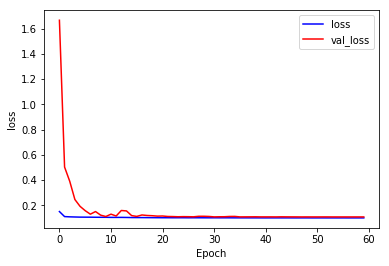

In [152]:
plt.plot( history.history['loss'], color = 'blue', label = 'loss')
plt.plot( history.history['val_loss'], color = 'red', label = 'val_loss')


plt.legend(loc="best")
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.savefig(f'results/{fname.stem}_loss.png')
plt.show()

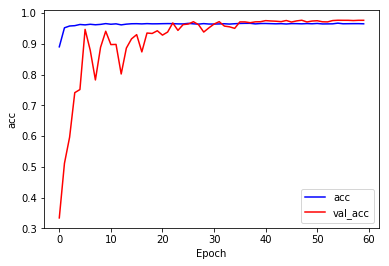

In [153]:
plt.plot( history.history['acc'], color = 'blue', label = 'acc')
plt.plot( history.history['val_acc'], color = 'red', label = 'val_acc')


plt.legend(loc="best")
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.savefig(f'results/{fname.stem}_acc.png')
plt.show()

In [154]:
result_test = model.evaluate(x_test, y_test[:, :3])
print('Accuracy of training Set:',result_test[1])
print('Loss of training set:', result_test[0])

9000/9000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 202us/step
Accuracy of training Set: 0.9768888888888889
Loss of training set: 0.107657244404157


In [155]:
endtime = datetime.datetime.now()
starttime = datetime.datetime.now()
y_pred = np.zeros(y_test.shape)

In [156]:
starttime = datetime.datetime.now()
y_pred = model.predict(x_test)
y_pred = np.concatenate([y_pred, np.full((len(y_test), 1), 0.)], axis=-1)
endtime = datetime.datetime.now()

print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 1.746297 sec
Average prediction execute time: 0.194033 ms


In [157]:
y_pred

array([[0.285301, 0.634882, 0.821613, 0.      ],
       [0.062023, 0.794278, 0.021673, 0.      ],
       [0.779134, 0.464756, 0.537178, 0.      ],
       [0.771305, 0.859158, 0.10143 , 0.      ],
       ...,
       [0.756505, 0.348852, 0.536145, 0.      ],
       [0.601123, 0.79253 , 0.41309 , 0.      ],
       [0.839638, 0.805168, 0.672039, 0.      ],
       [0.801392, 0.571378, 0.51841 , 0.      ]])

In [158]:
y_test

array([[0.225708, 0.523347, 0.668774, 0.      ],
       [0.033598, 0.544478, 0.025088, 0.      ],
       [0.996198, 0.614192, 0.650586, 0.      ],
       [0.893447, 0.947252, 0.100896, 0.      ],
       ...,
       [0.842233, 0.360574, 0.578223, 0.      ],
       [0.606511, 0.789246, 0.409031, 0.      ],
       [0.584925, 0.565939, 0.471009, 0.      ],
       [0.441016, 0.300737, 0.287652, 0.      ]])

est = quaternion2euler(y_pred); est

In [159]:
np.max(y_pred), np.max(y_train)

(0.9188581109046936, 0.9999939057340068)

In [160]:
successedT1 = 0
successedT2 = 0
successedT3 = 0
successedT4 = 0

maxofMax = 0
sumofMaxErr = 0
pred = None
errlist = []

for i in range(len(x_test)):
    
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    estrm = quaternion2rm(pred)
    lbrm = quaternion2rm(y_test[i])
    errrm = estrm @ np.transpose(lbrm)
    
    err = rm2theta(errrm)
        
    maxErr = np.abs(np.max(err) / 3.14 * 180)


    
    errlist.append(maxErr)
    
    if maxErr > maxofMax:
        maxofMax = maxErr

    if maxErr < 0.5:
        successedT1 = successedT1 + 1
    if maxErr < 1:
        successedT2 = successedT2 + 1
    if maxErr < 1.75:
        successedT3 = successedT3 + 1
    if maxErr < 2.5:
        successedT4 = successedT4 + 1


    print(maxErr)
    sumofMaxErr = sumofMaxErr + maxErr


0.6498593726944301
0.0
2.2683981937512345
2.7962795894508905
0.9731239695760461
2.112056364194284
1.7170241854094435
0.0
1.0668978889176544
0.29578965028561466
0.0
5.117925636994991
0.0
0.39515672223179577
0.0
0.0
0.8978045058407008
1.7650351705926257
2.2429482023555143
2.3024883104234357
0.0
0.0
2.251646498780637
0.3963240746211081
0.0
0.06664891463491243
0.363238850816638
0.5469169310031479
1.1665628579074199
0.07007684102984435
2.944855618977155
2.375884646449912
3.6842235779604717
1.946405838298376
1.489781715138836
1.3799768281821
2.3213888310049664
2.295611308715666
2.650955483104893
0.883527273846962
0.0
2.1430145220706533
0.0
1.154900658705573
1.7875271671812958
1.416550136685671
2.9698151751317945
0.8704795191624032
1.4482719256920622
0.011008690309071487
0.6944981840414983
0.9630559682294191
4.004438702538721
6.164475632980827
2.30354249770359
2.1036259442343312
2.035142941754165
0.14266401427409425
0.8730502634572281
2.7875052761294614
0.1575493387018287
1.7557860206890896
0

0.8009308347761603
0.48362867312850066
2.007713600250395
1.8441204446899988
0.8248048681621811
0.048942110224301026
0.498278510039925
0.0
1.5376550280750394
1.8464161685000577
1.6493835555885694
2.4782106467007803
3.3529888160847348
2.1680118994289717
2.136951297446947
1.1869534072351997
1.3593048569211024
0.0
1.1600475093976153
3.14105199086444
1.9036368400856478
1.6516791011944378
1.1351248012093313
0.0
0.8933249880607526
2.654996414390079
1.6009461037603625
3.2983250846381083
1.4514012211132052
2.319944210182573
2.3558407997413364
0.950632775178662
0.0
1.4493692122585535
0.056342104429234395
1.2514339317310397
0.19574591431333255
0.3634411544624215
2.7880084510429275
2.8841157328511824
1.2779342646489265
1.5465130499558555
0.9628256042991599
2.8188549616702243
0.1326643576206833
1.1034608959154022
3.23997588767168
0.5282564165416135
0.1273906968835108
0.0
0.044124597444253816
0.0
0.7307322531308346
0.38235970006298026
2.613738707129759
1.130635630382377
2.749962397551671
0.0
2.09460

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1.8793413920412192
0.4572392612904611
0.6820122148107828
1.2633031380331667
3.4117777497106427
3.411006508361505
0.13222946671610886
1.375179602021909
2.2604909904321713
0.19917769925969317
2.2346149700705182
2.827272960823319
2.007104900364515
1.882680016690051
1.2933141868392608
0.6525542324561485
0.0
0.0
1.2019252985961086
1.2433927791772241
1.841180547886572
0.5695032440579155
1.80497398547903
0.3357019050012875
1.0896948297495959
2.6911685048820293
2.6414517909135244
2.678515039734524
0.2930069167078573
0.22276152153438336
1.1837409909764396
0.0
0.07850376851662011
0.0
5.3140716233267895
1.5412891104704445
1.9936301083560724
0.9841851387791154
1.446062431893148
0.63583517828111
0.48304457712767307
0.4732656787059618
0.0
0.7613214598962166
2.005713027219785
0.8490276944865771
3.2348472585225214
0.8419384997344823
0.0
1.3652867247948421
1.1470150812295543
0.6774926623791466
1.5841488247248392
0.15252729494608494
0.8822305527810645
0.0
0.7855953760481836
2.4271875029225374
0.4868443

0.0
0.5383327991887007
2.392768456391099
3.070873233773053
3.2913996931603227
3.1833491043356537
0.17486477178463428
0.01853288601936689
0.15701917112832647
1.9014189748210368
4.085625890109415
0.0899735226363921
2.0836686851708968
0.0
0.0
1.996380969346001
2.1888064834949126
1.8443362514535304
0.0
0.9608597937048999
1.0235672795197561
1.7411309026605675
0.3212469491636882
2.6288464092175334
3.9909241004059415
1.5754335523902954
0.0
1.2738230909870054
1.531420503201447
5.961761072189351
2.2198060268987625
0.0
5.1953150038486795
1.973465892791317
1.478568366365627
1.4350258931573514
0.0
3.910578461816663
2.5807071938114703
8.440802223238668
0.5634561456680341
0.0
0.49732895238491903
0.07873890633018057
3.4509100225535616
0.5835349718093049
0.5162641845811743
0.8703610453686224
1.5476016163406419
1.3155026741683062
1.879009531796504
0.0
0.762845116495412
0.6090303587107315
0.5477378289056097
0.8583959256645768
1.7260718501315748
0.400454053212352
2.4306801379211724
0.4330183599270323
1.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0.7808232758188717
2.3669731930410873
3.0320814859815894
3.6500153980861465
1.245754189004118
0.28194703196323667
1.7674645095686334
1.9194492112275703
0.21757705099885025
3.8649577416585825
0.2250245310262511
0.9528511601382766
2.969916062070218
4.448949434371537
0.0
1.7003630241392036
1.6993040666776047
0.9019389656922523
0.0
1.2855027265824979
0.12985298080815444
2.1638205206515044
4.077613722015514
2.721144680437602
0.39021183705352414
1.3085642056249518
0.012804726454095796
0.8064776164235185
0.0
0.8288748511577687
1.506641317267119
3.401127364850898
1.146278369268307
0.3236138822624582
1.7770001425923478
0.09596923863788412
0.9261951472759041
1.4314100414034392
0.7693518138336083
0.5840270590552348
0.0
0.0
0.7041703409947584
0.5603923336320853
0.41765089962950463
3.285774459269733
0.0
1.288685840421586
0.0
4.4691922009422775
3.5816653471176103
0.0
2.255600908139699
0.0
2.0999233846381875
0.7266887974912742
0.0
0.6648983115624096
1.5941370468519465
1.9584296730723638
0.7187320251

1.2074348879068622
3.7148520449950553
0.0
1.2923731283052076
2.345658708866619
0.44465646886048665
1.944515506777058
0.8643384118273113
3.4491033684381978
1.271111983517
1.1642807457365507
0.7649013711646672
1.7560206019248568
2.643391378681627
0.17057243930826763
1.073512786820009
1.135918481340664
0.5272908432344976
0.0
0.4412340761252885
0.8190956975235579
0.8227993458537762
2.732320522992292
2.505284742735704
0.8054737379436783
1.1042522868747442
0.9277833559529429
0.09841076149466846
1.4660831645774062
4.014796548096593
0.20831342734134836
2.9800459475505523
0.20379016521184118
1.373726066249525
1.083926079629414
1.1324410699240988
0.0
0.3218457154162095
1.681358233081169
1.0077058644002752
0.2919342586592847
1.0766615060355789
0.0
0.9439106621215342
2.316651780630374
0.552292793463013
3.049174481012364
1.660778055425324
2.186494727003536
1.2579818361311503
0.5404096751778824
2.764656314383667
3.7342388203363566
1.110118291303134
1.6536589711106424
3.413665313013674
1.984888987658

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2.0100629792793514
0.9532093389562346
2.1914661268614894
0.0
2.8280268018142185
1.9957888600180453
0.0
0.0
3.1072722008111917
0.0
0.0
5.281090060663065
2.3503105155550004
0.9588864182402279
1.8948458625333044
2.295279094334569
0.6676164889512962
3.336327547675364
0.6774917807290769
1.6317015056758428
1.3433189955667861
0.0
2.686505937622624
1.1554091167104086
0.0
1.7087747425142226
0.0
3.1509021809360505
3.8898003227198217
1.5396265019223778
1.3975466882215462
1.2519383156468142
0.0
0.6262839311495579
0.6628323546984467
0.35376458847319997
2.2389880155742716
1.6678009313917026
1.5076513080057519
0.0
2.0922344649080076
2.0416249948593315
2.507004831041259
0.8447623445159214
0.8008108033031414
0.48811598765900477
0.9498400211463189
2.7506721280285804
1.1243126093261806
0.5638303392392338
0.353210888655423
3.333405634762032
0.0
0.10418020989635529
0.4571197247884371
0.2936350293683808
2.4279885332501685
1.4656912811911027
0.11312862267272289
0.0
0.2013800643452508
2.871502538173022
1.5951

0.9210684528634902
1.7756148515016192
0.0
1.9691669026207175
0.0
1.0304547072429135
2.668732650059813
1.8082470251930058
0.0
0.8960180718170598
4.768114888843503
1.0107901746658166
0.6031187082179558
3.9920855568047906
2.17242269043413
2.9147269507602487
1.9856704198137127
1.014846782602147
2.542387564056382
2.4037625482023186
0.7363654139090731
0.09063490980976255
0.25581861709680265
2.9482828633994576
1.8641448391155122
1.9484581667269134
0.09988475674077657
2.2281257066945543
0.10065722708061775
0.21505619605493081
0.6158085448842087
3.174051904045848
1.224115891621813
1.153928546747737
1.6378751905021782
0.0
0.6387760286001273
1.0500578980810913
1.0033955425299381
3.4054149959448283
1.662123037314
0.4412415320229343
0.0
0.005414628956030959
0.19040666742100218
0.861895219886292
2.725097098172782
0.0
1.1604325396895687
0.8470471108259953
0.0
1.6610404178453633
3.2561363328986133
3.0159829831540077
0.7576869773891998
0.0009853922827622438
1.0282192495370843
2.299075645598395
3.977632

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2.011933205047213
1.2826780121123391
0.0
2.312227312404256
0.7157506820570781
1.5754440424964187
0.2755107530666628
2.652502872062087
1.4108448598471015
0.0
2.760155758526232
2.162453200059371
0.8248913083305357
0.0
0.0
0.8116018712711704
0.0
0.651458406830881
0.0
1.5638276919129617
0.0
0.06079574161064521
1.1629630133955169
0.0
0.0
0.0
2.835097308230948
2.601880211547915
0.0
0.27157919127294405
1.7955043017967631
0.6782378414578641
0.20280608627608096
3.790502086047187
0.5458324616307225
1.2336535599228553
0.0
2.6717171076765274
0.0
1.0063255657327042
1.251185613604177
0.9113744421776591
0.0
0.029219817935048024
1.3434184108145826
0.7546759388369008
2.0202054301149133
2.1123874712568704
0.4631020389973984
0.35389897328998415
3.1326576438947638
0.3791841778301041
1.1569044845394874
1.3750460797941384
4.1478637580733135
1.2278626898883604
0.9696267360588157
2.770117277222981
0.3088812841337202
1.0659183890420898
0.28216810046352014
1.0288525360886545
0.9913718399239325
1.873145897025890

0.0
1.3407990583557734
0.0
2.2840434888189076
2.14226460233312
1.5754953487147845
0.07880279652036211
1.391361260226945
0.5909988796811251
0.5043240761508243
1.0631753906357644
1.540731890963144
3.298958241754637
0.7344143291683642
0.0
2.1451661172451386
0.1778855521583159
2.3970183940566545
0.0963303382765835
0.03966701879568564
2.9819971868822868
0.9360000081645475
0.0
1.2175116960101948
0.0
2.0675710043037
1.712633410975142
0.5792923732596204
2.171877060574684
1.458785882090737
2.0868119138387273
2.711073116189435
1.0636433943811283
0.5691929592568201
0.6565910751202392
1.3693814879733683
3.643477637577916
2.3502185233479165
2.689655468941646
2.601067616103756
0.5352255746233304
1.084243299850649
1.1265264627751241
0.45210104299799697
0.0
0.0
2.5505839634944167
1.7591162118353385
0.0
2.5923058737404268
3.1386124976000254
0.8600875473053728
0.0
0.9687917258028199
0.0
0.20181677133586629
2.2919320217953123
0.9554799582062827
0.0
2.264156463165693
1.5055471971064813
0.30506349661679405

In [161]:
print('Max degree error: %.4f degrees' % maxofMax)
print('Average degree error: %.4f degrees' % (sumofMaxErr / len(y_test)))
print(' T1: %.2f \n T2: %.2f \n T3: %.2f \n T4: %.2f \n' 
      % (successedT1 / len(y_test) * 100, 
         successedT2 / len(y_test) * 100, 
         successedT3 / len(y_test) * 100, 
         successedT4 / len(y_test) * 100))

Max degree error: 10.7975 degrees
Average degree error: 1.2910 degrees
 T1: 32.54 
 T2: 49.23 
 T3: 69.81 
 T4: 84.13 



In [162]:
print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 1.746297 sec
Average prediction execute time: 0.194033 ms


In [163]:
fname.stem

'bunny'

把圖片隨機選九張圖片秀出來，如果save為True會把結果存取下來

In [164]:
def show_pcd_3d(x_data, save=False, name='123'):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')

In [165]:
def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

In [166]:
x_test_no_scalar = scalar_reduction(x_test, x_train_max, x_train_min)

Text(0.5, 0.92, 'original')

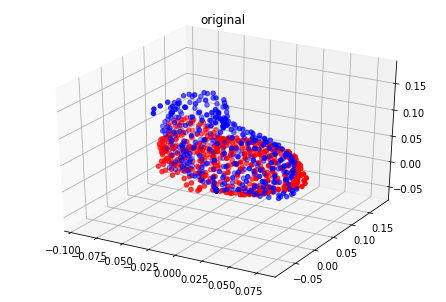

In [167]:
fig = plt.figure()
ax = Axes3D(fig)

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(x, y, z, c='r', marker='o')

x_test_sample = x_test_no_scalar[0].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('original')

In [168]:
x_test_est = []
data = np.asarray(downpcd.points)
rotateData = data.copy()

for i in range(len(x_test)):
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    rotateData = data.copy()
    for n in range(len(data)):
        rotateData[n] = rotate_with_q(data[n], pred)
        
    rotateData = rotateData.reshape(1, -1)
          
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    
    x_test_est.append(result.tolist())
    
x_test_est = np.array(x_test_est).reshape(len(x_test), -1, 3)

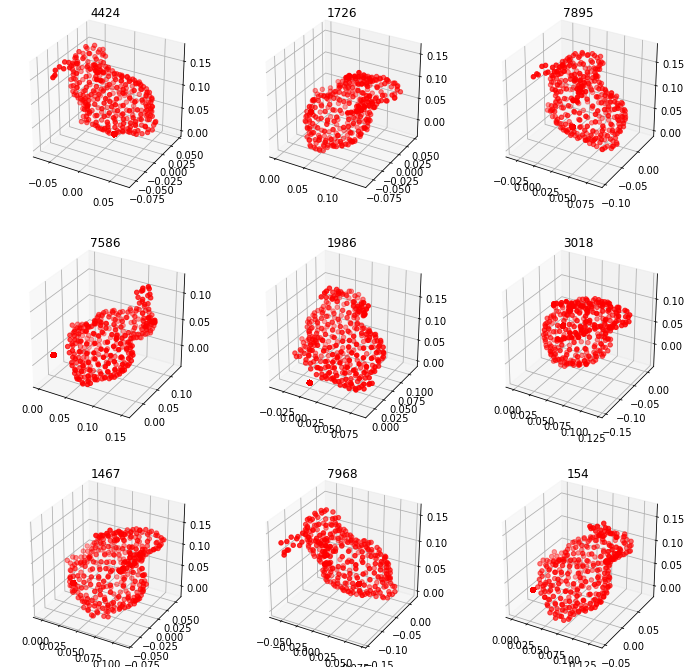

In [169]:
np.random.seed(0)
show_pcd_3d(x_test_no_scalar, save=True, name=fname.stem)

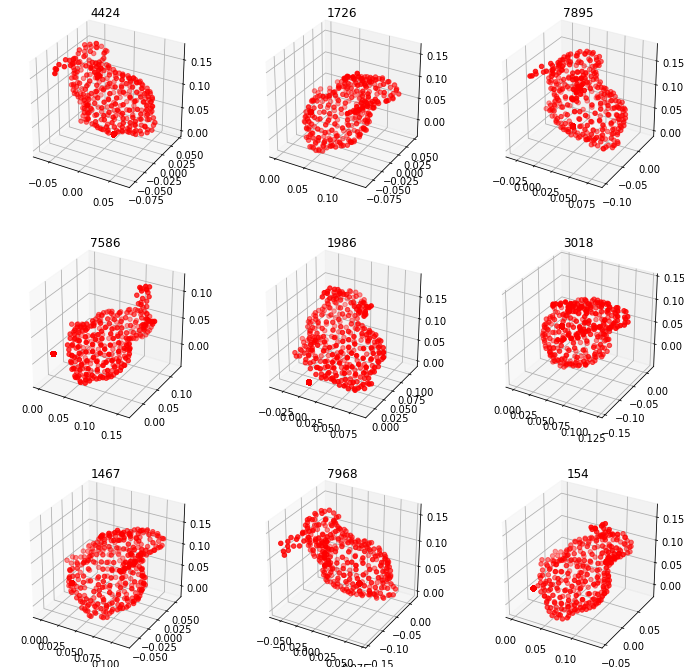

In [170]:
np.random.seed(0)
show_pcd_3d(x_test_est, save=True, name=fname.stem)

Text(0.5, 0.92, 'register')

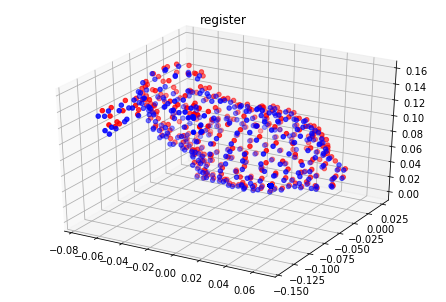

In [171]:
fig = plt.figure()
ax = Axes3D(fig)
data_ = x_test_no_scalar[5].reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='r', marker='o')


data_ = x_test_est[5].reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('register')

In [172]:
eva_rms(x_test_no_scalar[0], x_test_est[0])

0.013853582253532849

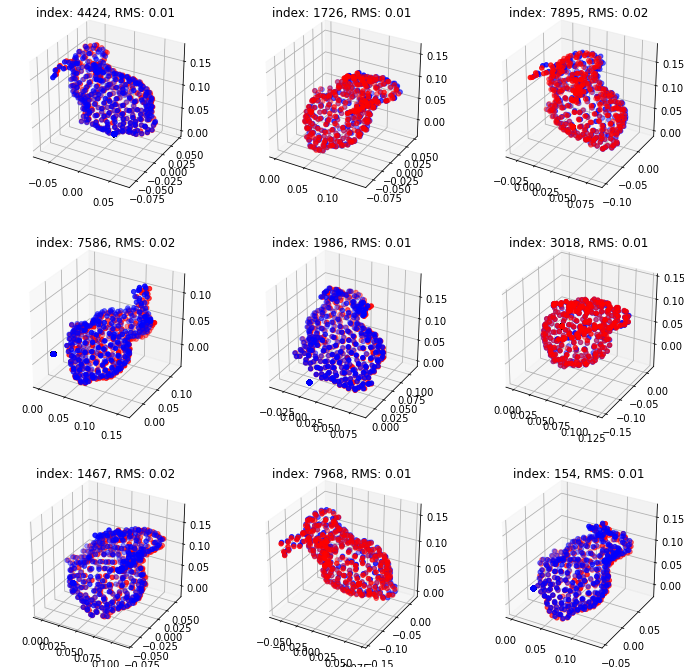

In [173]:
np.random.seed(0)
show_match_result(x_test_no_scalar, x_test_est, save=True, name=fname.stem)

In [174]:
rms = []
for i in range(len(x_test)):
    rms.append(eva_rms(x_test_no_scalar[i], x_test_est[i]))

print(f'Max RMS of {fname.stem} testing data: {np.max(rms):.2f}')
print(f'Min RMS of {fname.stem} testing data: {np.min(rms):.2f}')
print(f'Mean RMS of {fname.stem} testing data: {np.mean(rms):.2f}')

Max RMS of bunny testing data: 0.04
Min RMS of bunny testing data: 0.00
Mean RMS of bunny testing data: 0.02
